In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# Dataset raw URL (IBM / GitHub mirror)
DATA_URL = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

# Load
df = pd.read_csv(DATA_URL)
print("Shape:", df.shape)
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df.info()
# Convert TotalCharges to numeric (some rows are empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("Missing per column:\n", df.isnull().sum())

# Drop rows with missing TotalCharges (small number)
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# Drop customerID (identifier)
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

print("After dropping missing, shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
# Churn Rate
churn_rate = df['Churn'].map({'Yes':1,'No':0}).mean()
# ARPU ~ average monthly revenue per user (MonthlyCharges)
arpu = df['MonthlyCharges'].mean()
# Average tenure (ماه)
avg_tenure = df['tenure'].mean()
# Simple estimated LTV = MonthlyCharges * tenure (not discounting)
df['est_ltv'] = df['MonthlyCharges'] * df['tenure']
avg_ltv = df['est_ltv'].mean()

print(f"Churn rate: {churn_rate:.3%}")
print(f"ARPU (Average MonthlyCharges): {arpu:.2f}")
print(f"Average Tenure (months): {avg_tenure:.2f}")
print(f"Estimated avg LTV (MonthlyCharges * tenure): {avg_ltv:.2f}")

Churn rate: 26.578%
ARPU (Average MonthlyCharges): 64.80
Average Tenure (months): 32.42
Estimated avg LTV (MonthlyCharges * tenure): 2283.15


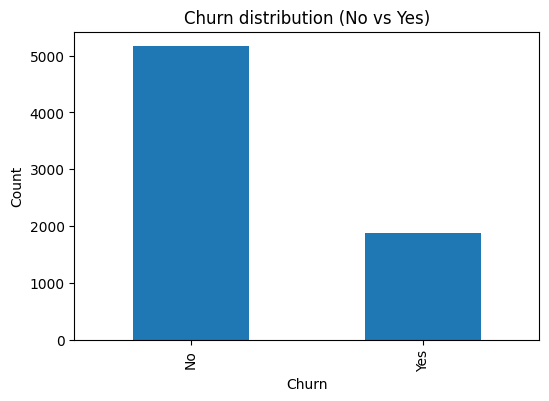

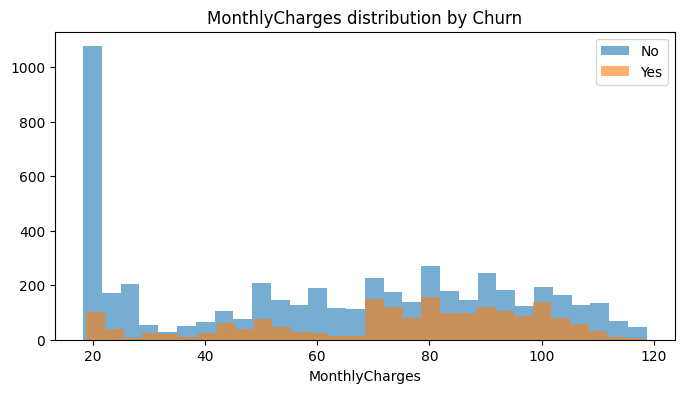

In [4]:
plt.figure(figsize=(6,4))
df['Churn'].value_counts().plot(kind='bar')
plt.title('Churn distribution (No vs Yes)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df[df['Churn']=='No']['MonthlyCharges'], alpha=0.6, bins=30, label='No')
plt.hist(df[df['Churn']=='Yes']['MonthlyCharges'], alpha=0.6, bins=30, label='Yes')
plt.title('MonthlyCharges distribution by Churn')
plt.xlabel('MonthlyCharges')
plt.legend()
plt.show()

In [5]:
# Encode target
df['ChurnLabel'] = df['Churn'].map({'Yes':1,'No':0})

# Select features: make a simple pipeline: encode categoricals -> one-hot
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
# exclude target (Churn) and any columns we engineered
cat_cols = [c for c in cat_cols if c not in ['Churn']]

df_model = pd.get_dummies(df.drop(columns=['Churn']), columns=cat_cols, drop_first=True)

# Features & target
X = df_model.drop(columns=['ChurnLabel','est_ltv'], errors='ignore')  # we can drop est_ltv if we want
y = df_model['ChurnLabel']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling numeric features
num_cols = ['tenure','MonthlyCharges','TotalCharges']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [6]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.8045486851457001
ROC AUC: 0.8360714082341553

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

Confusion Matrix:
 [[918 115]
 [160 214]]


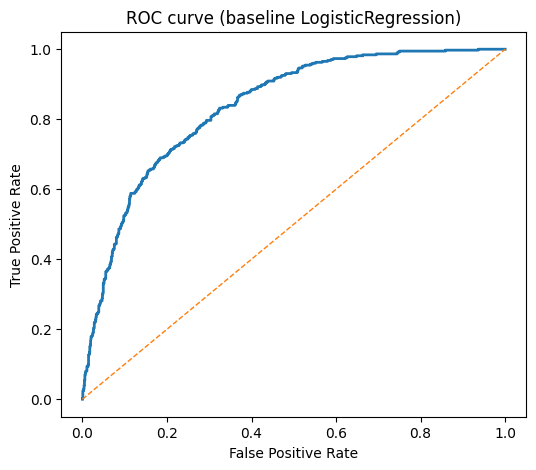

In [7]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], '--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (baseline LogisticRegression)')
plt.show()

In [8]:
import joblib
joblib.dump(model, 'telco_churn_baseline_model.joblib')
joblib.dump(scaler, 'telco_churn_scaler.joblib')
print("Saved model and scaler to current directory.")

Saved model and scaler to current directory.


In [9]:
!pip install xgboost lightgbm shap --quiet

In [10]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [11]:
# XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# predict
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:,1]

# eval
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:57:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.7768301350390903
XGBoost ROC-AUC: 0.8195083630565664

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1033
           1       0.59      0.53      0.56       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [12]:
!pip install lightgbm

In [13]:
# LightGBM classifier
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)

# predict
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:,1]

print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("LightGBM ROC-AUC:", roc_auc_score(y_test, y_proba_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [14]:
#Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

# ensemble_model = VotingClassifier(
#     estimators=[
#         ('lr', LogisticRegression(max_iter=1000)),
#         ('xgb', xgb_model),
#         ('lgb', lgb_model)
#     ],
#     voting='soft'
# )

# ensemble_model.fit(X_train, y_train)

# y_pred_ens = ensemble_model.predict(X_test)
# y_proba_ens = ensemble_model.predict_proba(X_test)[:,1]

# print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ens))
# print("Ensemble ROC-AUC:", roc_auc_score(y_test, y_proba_ens))

In [15]:
# from sklearn.metrics import accuracy_score, roc_auc_score
# # Preds on Train
# train_preds = ensemble_model.predict(X_train)
# print("Train Accuracy:", accuracy_score(y_train, train_preds))
# print("Train ROC-AUC:", roc_auc_score(y_train, ensemble_model.predict_proba(X_train)[:,1]))

NameError: name 'ensemble_model' is not defined

In [16]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Base Models
base_models = [
    ('logistic', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
]

#Meta Model
meta_model = LogisticRegression(max_iter=1000)

# === Stacking Ensemble ===
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method='auto',
    passthrough=True,
    n_jobs=-1
)

#train
stack_model.fit(X_train, y_train)

# predict
y_pred = stack_model.predict(X_test)
y_score = stack_model.predict_proba(X_test)[:, 1]

#metrics
stack_accuracy = accuracy_score(y_test, y_pred)
stack_auc = roc_auc_score(y_test, y_score)

print("🔻 Stacking Ensemble Results (Fixed for Ridge)")
print(f"Accuracy: {stack_accuracy}")
print(f"ROC-AUC: {stack_auc}")

#save
results_df = pd.DataFrame({
    'Model': ['Stacking Ensemble (Logistic + RF + XGB + LGBM + Ridge Meta)'],
    'Accuracy': [stack_accuracy],
    'ROC-AUC': [stack_auc]
})

results_df.to_csv('stacking_results.csv', index=False)
print("✅ نتایج ذخیره شد: stacking_results.csv")
results_df

🔻 Stacking Ensemble Results (Fixed for Ridge)
Accuracy: 0.8024164889836531
ROC-AUC: 0.8372827701880716
✅ نتایج ذخیره شد: stacking_results.csv


,Model,Accuracy,ROC-AUC
0,Stacking Ensemble (Logistic + RF + XGB + LGBM ...,0.802416,0.837283


In [17]:
# # DataFrame
# results_df = pd.DataFrame({
#     'Model': ['Stacking Ensemble (Logistic + RF + XGB + LGBM)'],
#     'Accuracy': [stack_accuracy],
#     'ROC-AUC': [stack_auc]
# })

# #save
# results_df.to_csv('stacking_results.csv', index=False)

# print("✅ نتایج ذخیره شد: stacking_results.csv")
# results_df

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


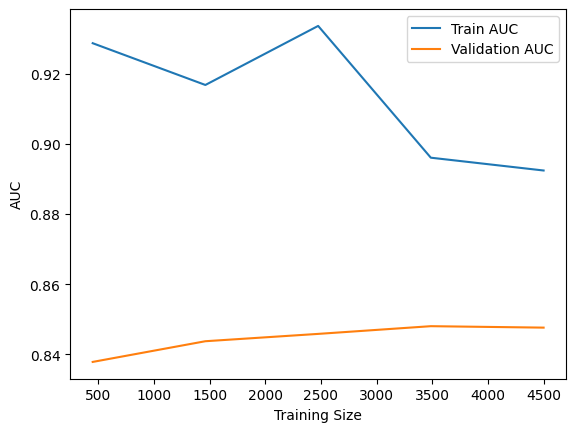

In [18]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    stack_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, train_sizes=np.linspace(0.1,1,5)
)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation AUC')
plt.xlabel('Training Size')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [19]:
models = [
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('RandomForest', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('XGBoost', XGBClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42
    )),
    ('LightGBM', LGBMClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=-1,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )),
    ('stack_model', stack_model)
]

results = []

for name, model in models:

    if name != 'stack_model':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
    else:
        y_pred = model.predict(X_test)
        y_score = model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)
    results.append({'Model': name, 'Accuracy': acc, 'ROC-AUC': auc})

# ذخیره همه نتایج در CSV
results_df = pd.DataFrame(results)
results_df.to_csv('all_models_results.csv', index=False)
print("✅ تمام نتایج مدل‌ها ذخیره شد: all_models_results.csv")
results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
✅ تمام نتایج مدل‌ها ذخیره شد: all_models_results.csv


,Model,Accuracy,ROC-AUC
0,LogisticRegression,0.804549,0.836071
1,RandomForest,0.786780,0.817219
2,XGBoost,0.786780,0.831027
3,LightGBM,0.788913,0.825836
4,stack_model,0.802416,0.837283


In [20]:
import shap


# === KPI Calculations ===

# Churn Rate
churn_rate = df['Churn'].value_counts(normalize=True).get('Yes', 0)
print(f"Churn Rate: {churn_rate:.2%}")

# ARPU (Average Revenue Per User)
arpu = df['MonthlyCharges'].mean()
print(f"Average Revenue Per User (ARPU): {arpu:.2f}")

# Average Tenure (months)
avg_tenure = df['tenure'].mean()
print(f"Average Tenure (months): {avg_tenure:.2f}")

# Simple Estimated LTV
ltv = arpu * avg_tenure
print(f"Estimated LTV: {ltv:.2f}")

# === Feature Importance / Insight ===
def stacked_predict_class(X):
    return stack_model.predict(X)

Churn Rate: 26.58%
Average Revenue Per User (ARPU): 64.80
Average Tenure (months): 32.42
Estimated LTV: 2100.87


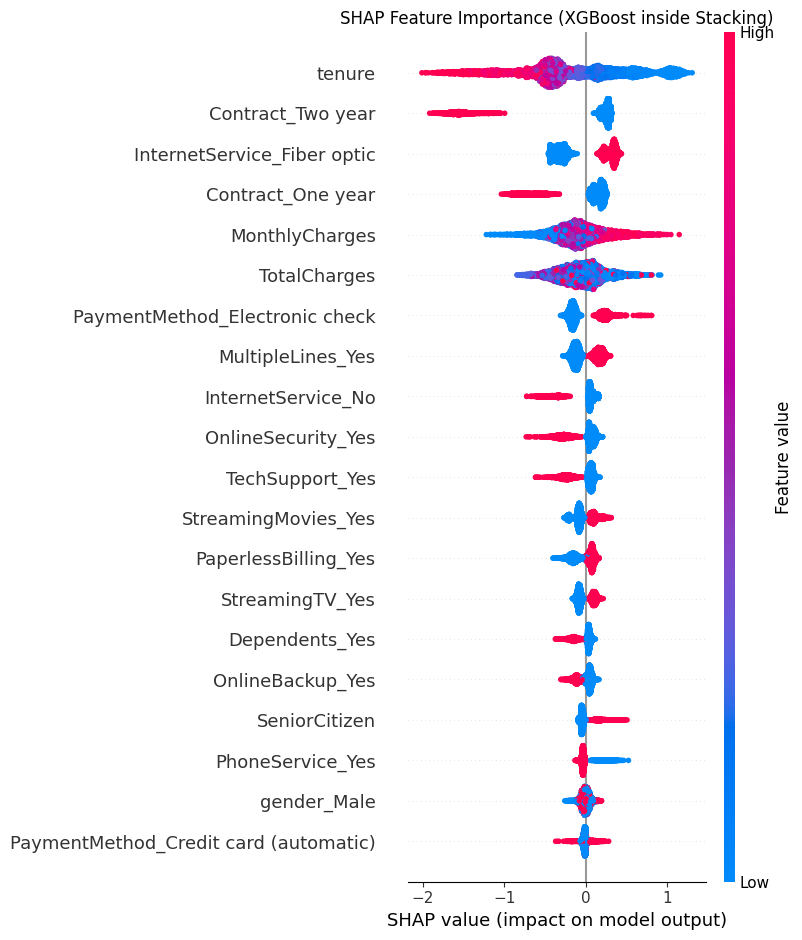

In [22]:
import shap
xgb_model = None
for name, model in stack_model.named_estimators_.items():
    if name == 'xgb':
        xgb_model = model
        break

# Safety check
if xgb_model is None:
    raise ValueError("XGBoost model not found in stacking ensemble.")

# Initialize SHAP Explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Feature Importance Summary Plot
plt.title("SHAP Feature Importance (XGBoost inside Stacking)")
shap.summary_plot(shap_values, X_train)

In [23]:
!git --version

git version 2.34.1


In [24]:
!git clone https://github.com/fatemesima/Business-data-analysis

Cloning into 'Business-data-analysis'...


In [27]:
cp /content/IBMTelcoChurn.ipynb/content/Business-data-analysis/

cp: missing destination file operand after '/content/IBMTelcoChurn.ipynb/content/Business-data-analysis/'
Try 'cp --help' for more information.
